In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import statistics
from operator import sub, mul, pow
from scipy.signal import savgol_filter


In [19]:
df = pd.read_csv("Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
loads = np.asarray(df["crawfordCrescent_F2"])

In [20]:
def Norm4_Diff(a, b):
    return (a**4 + b**4) ** (1/4)

In [21]:
h = 48
d = 160
N = 10
F_i = np.zeros((48,N))
G_i = np.zeros((48,N))
Gbar_i = np.zeros((48,N))
F_1 = np.zeros(48)

for j in range(48):
    F_1[j] = statistics.median(loads[h*(d-N)+j : d*h+j : h])   # Gives d+1

for i in range(N):
    G_i[:,i] = loads[h*(d-(7*i+7)):h*(d-(7*i+6))]

    for j in range(48):
       
        Gbar_i[j,i] = Norm4_Diff(F_i[j,i], G_i[j,i])
    
    for j in range(i+1):
        F_i[:,i] += (F_1 + Gbar_i[:,j])
    #print(F_i[:,i])
    F_i[:,i] = F_i[:,i] * (1/(i+2))








<function matplotlib.pyplot.show(*args, **kw)>

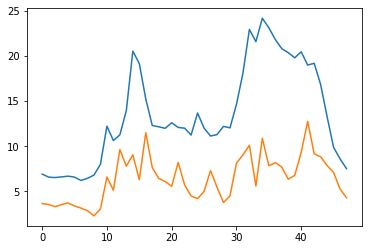

In [22]:
y = list(range(48))
plt.plot(y,F_i[:,9])
plt.plot(y,loads[h*(d-4):(d-3)*h])
plt.show

In [23]:
load_data = np.loadtxt("Final/forecastData.txt")
forecast_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)
forecast_data.shape
x = forecast_data[0]

In [24]:
def FindBounds(data):
     UpperBound = []
     LowerBound = []
     for feeder in range(data.shape[0]):
          UpperBound.append(np.quantile(data[feeder], 0.75, axis=0))
          LowerBound.append(np.quantile(data[feeder], 0.25, axis=0))
     return np.asarray(UpperBound), np.asarray(LowerBound)

In [25]:
UpperBounds, LowerBounds = FindBounds(forecast_data)

In [26]:
# loadsReshape = np.reshape(loads, (365, 48))
# UpperBound = np.quantile(loadsReshape, 0.75, axis=0)
# LowerBound = np.quantile(loadsReshape, 0.25, axis=0)

In [27]:
A_peak = 1.1
h = 48

forecast_F1 = np.empty((18, 30, 48))
for feeder in range(forecast_data.shape[0]):
    for day in range(forecast_data.shape[1]):
        dayLoads = forecast_data[feeder][day]
        UpperBound = UpperBounds[feeder]
        LowerBound = LowerBounds[feeder]
        MidPoint = (UpperBound - LowerBound) / 2
        for i in range(h):
            if (dayLoads[i] - MidPoint[i]) > MidPoint[i]:
                forecast_F1[feeder][day][i] = ((1-(UpperBound[i]-dayLoads[i])/(UpperBound[i]-MidPoint[i]))*A_peak)*dayLoads[i]
            else:
                forecast_F1[feeder][day][i] = ((1-(MidPoint[i]-dayLoads[i])/(MidPoint[i]-LowerBound[i]))*A_peak)*dayLoads[i]


<function matplotlib.pyplot.show(*args, **kw)>

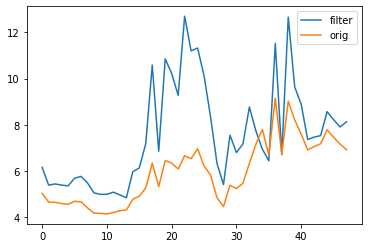

In [28]:
y = list(range(48))
plt.plot(y,forecast_F1[0][0], label="filter")
plt.plot(y,forecast_data[0][0], label="orig")
plt.legend()
plt.show



In [29]:
def WidenPeakLate(F2, Pmax, i, W):
    if i+1+W > 47:
        return F2
    F2[i+1+W] = F2[i+1]
    diff = (F2[i] - F2[i+1])/(W+1)
    for j in range(W):
        F2[i+W-j] = F2[i+1+W] + (j+1)*diff
    return F2

def WidenPeakEarly(F2, Pmax, i, W):
    if i-1-W < 0:
        return F2
    F2[i-1-W] = F2[i-1]
    diff = (F2[i] - F2[i-1])/(W+1)
    for j in range(W):
        F2[i-W+j] = F2[i-1-W] + (j+1)*diff
    return F2


In [30]:
forecast_F2 = np.array(forecast_F1)
F1 = np.array(forecast_F1)
Wpeak = 1
Npeak = 3

for feeder in range(forecast_data.shape[0]):
    for day in range(forecast_data.shape[1]):
        for i in range(Npeak):
            Pmax = max(F1[feeder][day])
            Pmax_pos = np.argmax(F1[feeder][day])
            forecast_F2[feeder][day] = WidenPeakLate(forecast_F2[feeder][day], Pmax, Pmax_pos, Wpeak)
            forecast_F2[feeder][day] = WidenPeakEarly(forecast_F2[feeder][day], Pmax, Pmax_pos, Wpeak)
            F1[feeder][day][Pmax_pos] = 0


<function matplotlib.pyplot.show(*args, **kw)>

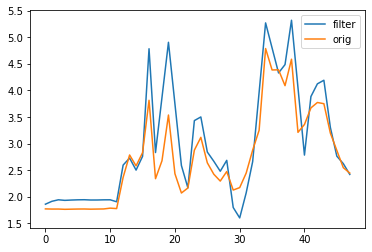

In [31]:
y = list(range(48))
plt.plot(y,forecast_F2[4][2], label="filter")
plt.plot(y,forecast_data[4][2], label="orig")
plt.legend()
plt.show

In [32]:
forecast_F3 = np.empty((forecast_data.shape[0], forecast_data.shape[1], forecast_data.shape[2]))

for feeder in range(forecast_data.shape[0]):
    for day in range(forecast_data.shape[1]):
        forecast_F3[feeder][day] = savgol_filter(forecast_F2[feeder][day], 11, 6)

<function matplotlib.pyplot.show(*args, **kw)>

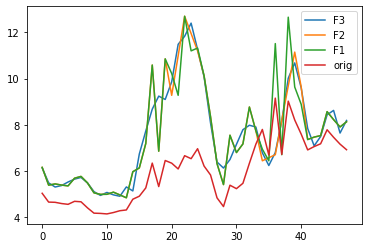

In [33]:
y = list(range(48))
plt.plot(y,forecast_F3[0][0], label="F3")
plt.plot(y,forecast_F2[0][0], label="F2")
plt.plot(y,forecast_F1[0][0], label="F1")
plt.plot(y,forecast_data[0][0], label="orig")
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

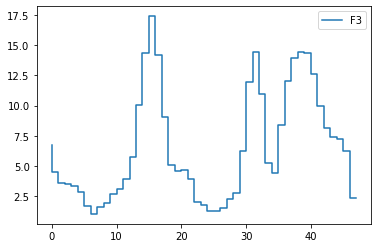

In [13]:
y = list(range(48))
plt.step(y,L_filter, label="F3")
#plt.plot(y,day_F2, label="F2")
#plt.plot(y,day_F1, label="F1")
#plt.plot(y,day, label="orig")
plt.legend()
plt.show

In [14]:
def FindSecondLargest(X):
    maxX = max(X)
    toDelete = []
    for i in range(len(X)):  
        if X[i] == maxX:
            toDelete.append(i)
    X_new = np.delete(X, toDelete)
    secondMax = max(X_new)
    secondPos = np.where(X==secondMax)[0][0]
    return secondMax

def isValidChargeRate(Fk, C, D):
    if Fk >= -D and Fk <= C:
        return True
    return False


def SchedulingAlgorithmIteration(F, Charge, StateOfCharge, C, D, SOC):
    
    SetPointValue = FindSecondLargest(F)
    print(SetPointValue)
    for i, val in enumerate(F):
        # Check if value is above setpoint
        if val >= SetPointValue:
            # If so, find value to come down to
            diff = val - SetPointValue
            # Check if discharge rate is valid
            if isValidChargeRate(Charge[i]-diff,C, D):
                # If valid, set to discharge at the diff value
                Charge[i] += -diff
            else:
                # Otherwise, discharge will be max and diff is max discharge
                Charge[i] = -D
                diff = D
            # Remove diff from this value
            F[i] -= diff

            # Loop to distribute this load
            j = 1
            while diff > 0:
                # Check if adding full availible charge would increase load to above setpoint
                if F[i-j] + (C-Charge[i-j]) > SetPointValue:
                    # If so decrease diff
                    diff -= SetPointValue - F[i-j]
                    if diff < 0:
                        diff += SetPointValue - F[i-j]
                        break
                    # Then increase value up to setpoint
                    if isValidChargeRate(Charge[i-j]+(SetPointValue-F[i-j]), C, D):
                        Charge[i-j] += SetPointValue - F[i-j]
                        F[i-j] = SetPointValue
                    else:
                        F[i-j] += (SetPointValue-F[i-j]) + Charge[i-j] - C
                        Charge[i-j] = C
                else:
                    # Else, diff will decrease by full availible charge amount 
                    diff -= (C-Charge[i-j])
                    if diff < 0:
                        diff += (C-Charge[i-j])
                        break
                    # C
                    if isValidChargeRate()
                    F[i-j] += C

                j += 1
            F[i-j] += diff
            
    return F, Charge, StateOfCharge

In [15]:
L_filter = np.array(day_F3)

e = 0.0001
M = 16
N = 48 
SOC = max(loads)*0.25
D = max(loads)*0.25
C = D/2
F = np.array(L_filter)

E = []
E.append(max(F))

Charge = np.zeros(48)
StateOfCharge = np.zeros(48)

for i in range(M):
    Fplus1, Chargeplus1, StateOfChargeplus1 = SchedulingAlgorithmIteration(F, Charge, StateOfCharge, C, D, SOC)
    F = np.array(Fplus1)
    Charge = np.array(Chargeplus1)
    StateOfCharge = np.array(StateOfChargeplus1)
    E.append(max(F))
    if abs(E[i+1] - E[i]) < e:
        break

Charge = F - day_F3
StateOfCharge = np.cumsum(Charge)

14.465584298438511
14.437321030824432
14.365375995733055
14.197593588016092
13.460020398950443
12.957962643005049
12.634283296518124
11.268125169439433
10.974344290813077
10.863753240839033
9.981389667341128
9.078190717970612
8.1427785555622
7.371627305230512
7.216543165573562
6.74531902294971


<bound method Figure.show of <Figure size 1080x576 with 2 Axes>>

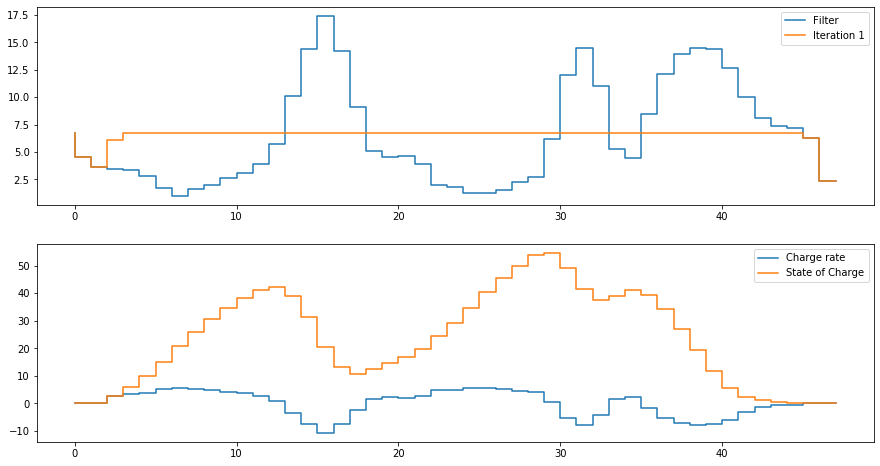

In [16]:
y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].step(y,day_F3, label="Filter")
axs[0].step(y,F, label="Iteration 1")
axs[0].legend()
axs[1].step(y,Charge,label="Charge rate")
axs[1].step(y,StateOfCharge,label="State of Charge")
axs[1].legend()
#plt.plot(y,day_F1, label="F1")
#plt.plot(y,day, label="orig")
fig.set_figheight(8)
fig.set_figwidth(15)
fig.show

In [17]:
x1 = sum(F)
x2 = sum(L_filter)
print(abs(-2))

2


In [34]:
load_data = np.loadtxt("Final/filterData.txt")
filter_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

load_data = np.loadtxt("Final/forecastData.txt")
forecast_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

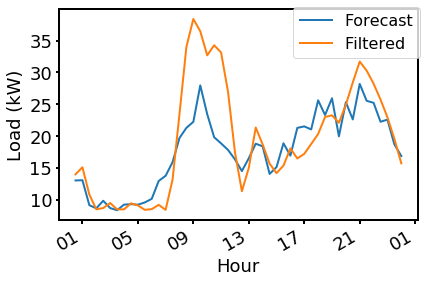

In [43]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[0:48], forecast_data[9][0], label="Forecast",linewidth=2)
ax.plot(df["Timestamp"].iloc[0:48], filter_data[9][0], label="Filtered",linewidth=2)
xloc = mdates.HourLocator(interval=4)
ax.xaxis.set_major_locator(xloc)
#ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)", fontsize=18)
ax.set_xlabel("Hour", fontsize=18)

#ax = plt.gca()
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
# for axis in ['top','right']:
#   ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)
# ax.set_xlim([-20, 20])
# ax.set_ylim([-5, 50])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
fig.legend( prop={'size': 16})
fig.set_figheight(4)
fig.set_figwidth(6)

plt.tight_layout()
plt.savefig("filter.svg", format='svg', dpi=1500, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[0:48], filter_data[9][0], label="Forecast",linewidth=2)
xloc = mdates.HourLocator(interval=4)
ax.xaxis.set_major_locator(xloc)
#ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)", fontsize=18)
ax.set_xlabel("Hour", fontsize=18)

#ax = plt.gca()
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
# for axis in ['top','right']:
#   ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)
# ax.set_xlim([-20, 20])
# ax.set_ylim([-5, 50])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
fig.set_figheight(4)
fig.set_figwidth(6)

plt.tight_layout()
plt.savefig("filter.svg", format='svg', dpi=1500, bbox_inches="tight")
plt.show()